
Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms


In [2]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install torchsummary

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-01ei_d35
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-01ei_d35
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=74f76bbd7dbf8e4d34dfa99d31e00ecfd49f81157e5625af3ce475fe3520ad1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-e36g781a/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!cd drive

In [6]:
from torchsummary import summary

In [39]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
dropout_value = 0.02

from enum import Enum
class Regulaization(Enum):
  BNORM = 'BN'
  LNORM = 'LN'
  GNORM = 'GN'

class Net(nn.Module):
  def __init__(self,regularization_type=Regulaization.BNORM,group_num=1):
      super(Net, self).__init__()
      self.regularizer = regularization_type
      self.group_num = group_num
      self.conv1 = nn.Sequential(
          nn.Conv2d(3, 32, 3,padding=1,bias=False),  
          nn.ReLU(),
          self.add_regularizer(32),
          nn.Dropout2d(dropout_value),

          nn.Conv2d(32, 64, 3,padding=1,bias=False),
          nn.ReLU(),
          self.add_regularizer(64),
          nn.Dropout2d(dropout_value),

          nn.Conv2d(64, 128, 3,padding=1,bias=False),
          nn.ReLU(),
          self.add_regularizer(128),
          nn.Dropout2d(dropout_value),
      )
      
      self.trans1 = nn.Sequential(
          nn.Conv2d(128, 16, 1,stride=2),
          nn.ReLU(),
      )
      self.conv2 =  nn.Sequential(
          nn.Conv2d(16, 32, 3,padding=1,bias=False,dilation=2), 
          nn.ReLU(),
          self.add_regularizer(32),
          nn.Dropout2d(dropout_value),

          nn.Conv2d(32, 32, 3,padding=1,bias=False),  
          nn.ReLU(),
          self.add_regularizer(32),
          nn.Dropout2d(dropout_value),

          nn.Conv2d(32, 32, 3,padding=1,groups=32,bias=False,dilation=2),
          nn.Conv2d(32,64,1,padding=1,bias=False),
          nn.ReLU(),
          self.add_regularizer(64),
          nn.Dropout2d(dropout_value), 
      )
      
      self.trans2 = nn.Sequential(
          nn.Conv2d(64, 32, 1,bias=False,stride=2),
          nn.ReLU(),
      )
      self.conv3 = nn.Sequential(
          nn.Conv2d(32,64, 3,padding=1,bias=False,dilation=2),
          nn.ReLU(),
          self.add_regularizer(64),
          nn.Dropout2d(dropout_value),    
      )
      self.gap = nn.Sequential(
          nn.AdaptiveAvgPool2d(1)
      )
      self.trans3 = nn.Sequential(
          nn.Conv2d(64,16,1,stride=2),
          nn.ReLU(),
      )

      self.conv4 = nn.Sequential(
          nn.Conv2d(16, 32, 3,padding=1,bias=False),
          nn.ReLU(),
          self.add_regularizer(32),
          
          nn.Conv2d(32,32,3,padding=1,groups=32,bias=False),
          nn.Conv2d(32,10,1,padding=1,bias=False),
          nn.ReLU(),
          self.add_regularizer(10),
          )
          # nn.BatchNorm2d(16),)
    #   self.conv5 = nn.Sequential(nn.Conv2d(16,10,1,bias=False))

  def forward(self, x):
    x = self.conv1(x)
    # x = self.pool1(x)
    x = self.trans1(x)
    x = self.conv2(x)
    x = self.trans2(x)
    x = self.conv3(x)
    x = self.trans3(x)
    # x = self.gap(x)
    x = self.conv4(x)
    # x = self.conv5(x)
    x = self.gap(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim=1)

  def add_regularizer(self,out_channel):
    """
    Returns regulaizer BN/LN/GN
    """
    if self.regularizer == Regulaization.BNORM:
      return nn.BatchNorm2d(out_channel)
    elif self.regularizer == Regulaization.LNORM:
      return nn.GroupNorm(1,out_channel)
    return nn.GroupNorm(self.group_num,out_channel)


In [37]:

class CIFAR10Model(nn.Module):

    def __init__(self, dropout_value=0.25):

        self.dropout_value = dropout_value  # dropout value

        super(CIFAR10Model, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )  # output_size = 32

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )  # output_size = 32

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32,
                      kernel_size=(1, 1), padding=0, bias=False),
        )  # output_size = 32
        self.pool1 = nn.MaxPool2d(2, 2)  # output_size = 16

        # CONVOLUTION BLOCK 2
        # DEPTHWISE CONVOLUTION AND POINTWISE CONVOLUTION
        self.depthwise1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=(3, 3), padding=0, groups=32, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )  # output_size = 16
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )  # output_size = 16

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2)  # output_size = 8

        # CONVOLUTION BLOCK 3
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=(3, 3), padding=4, dilation=2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )  # output_size = 11
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )  # output_size = 11

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2)  # output_size = 5

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )  # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(self.dropout_value)
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10,
                      kernel_size=(1, 1), padding=0, bias=False),
        )

        self.dropout = nn.Dropout(self.dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.depthwise1(x)
        x = self.convblock4(x)
        x = self.pool2(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool3(x)
        x = self.gap(x)
        x = self.convblock7(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [25]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [40]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 30, 30))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
              ReLU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
         Dropout2d-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 64, 30, 30]          18,432
              ReLU-6           [-1, 64, 30, 30]               0
       BatchNorm2d-7           [-1, 64, 30, 30]             128
         Dropout2d-8           [-1, 64, 30, 30]               0
            Conv2d-9          [-1, 128, 30, 30]          73,728
             ReLU-10          [-1, 128, 30, 30]               0
      BatchNorm2d-11          [-1, 128, 30, 30]             256
        Dropout2d-12          [-1, 128, 30, 30]               0
           Conv2d-13           [-1, 16, 15, 15]           2,064
             ReLU-14           [-1

In [27]:
import albumentations
from albumentations.pytorch import ToTensorV2

# Dataset and Creating Train/Test Split

In [28]:
train_transforms = albumentations.Compose(
                                    [albumentations.HorizontalFlip(),
                                    albumentations.ShiftScaleRotate(),
                                    albumentations.CoarseDropout(max_holes=1,max_height=16,max_width=16,min_holes=1, min_height=16, min_width=16,fill_value=0.47),
                                    albumentations.Normalize((0.4914, 0.48216, 0.44653), (0.24703, 0.24349, 0.26159)),
                                    ToTensorV2()
                                    ])
# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.48216, 0.44653), (0.24703, 0.24349, 0.26159))
                                       ])

class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=Transforms(train_transforms))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Visualize dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 274, 274])
  car   dog  frog truck


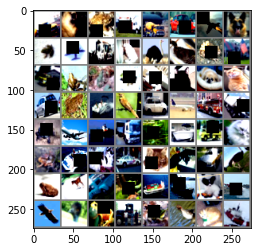

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(img.size())
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images['image']))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Training and Testing

All right, so we have 1.1M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [30]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch,loss_function):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data['image'].to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = loss_function(y_pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)
  train_losses.append(train_loss / len(train_loader))

def test(model, device, test_loader,loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output,target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [34]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
loss_function = nn.CrossEntropyLoss()
EPOCHS = 35
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch,loss_function)
    scheduler.step()
    test(model, device, testloader,loss_function)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.5454978942871094 Batch_id=781 Accuracy=33.66: 100%|██████████| 782/782 [00:20<00:00, 37.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3856, Accuracy: 4554/10000 (45.54%)

EPOCH: 1


Loss=1.2555915117263794 Batch_id=781 Accuracy=42.78: 100%|██████████| 782/782 [00:20<00:00, 37.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3439, Accuracy: 5045/10000 (50.45%)

EPOCH: 2


Loss=1.7033181190490723 Batch_id=781 Accuracy=47.20: 100%|██████████| 782/782 [00:20<00:00, 38.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3161, Accuracy: 5532/10000 (55.32%)

EPOCH: 3


Loss=1.7542121410369873 Batch_id=781 Accuracy=50.11: 100%|██████████| 782/782 [00:20<00:00, 37.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2872, Accuracy: 5921/10000 (59.21%)

EPOCH: 4


Loss=1.8115260601043701 Batch_id=781 Accuracy=54.17: 100%|██████████| 782/782 [00:20<00:00, 37.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2594, Accuracy: 6290/10000 (62.90%)

EPOCH: 5


Loss=1.477262020111084 Batch_id=781 Accuracy=55.64: 100%|██████████| 782/782 [00:20<00:00, 37.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2550, Accuracy: 6368/10000 (63.68%)

EPOCH: 6


Loss=1.2585285902023315 Batch_id=781 Accuracy=56.34: 100%|██████████| 782/782 [00:20<00:00, 37.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2500, Accuracy: 6481/10000 (64.81%)

EPOCH: 7


Loss=1.1363887786865234 Batch_id=781 Accuracy=56.52: 100%|██████████| 782/782 [00:20<00:00, 37.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2469, Accuracy: 6524/10000 (65.24%)

EPOCH: 8


Loss=1.2074800729751587 Batch_id=781 Accuracy=57.21: 100%|██████████| 782/782 [00:20<00:00, 37.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2447, Accuracy: 6534/10000 (65.34%)

EPOCH: 9


Loss=1.4789963960647583 Batch_id=781 Accuracy=57.51: 100%|██████████| 782/782 [00:20<00:00, 37.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2427, Accuracy: 6571/10000 (65.71%)

EPOCH: 10


Loss=1.1438630819320679 Batch_id=781 Accuracy=57.42: 100%|██████████| 782/782 [00:20<00:00, 37.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2430, Accuracy: 6541/10000 (65.41%)

EPOCH: 11


Loss=1.3825101852416992 Batch_id=781 Accuracy=57.73: 100%|██████████| 782/782 [00:20<00:00, 37.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2418, Accuracy: 6602/10000 (66.02%)

EPOCH: 12


Loss=1.45911705493927 Batch_id=781 Accuracy=57.35: 100%|██████████| 782/782 [00:20<00:00, 38.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2422, Accuracy: 6584/10000 (65.84%)

EPOCH: 13


Loss=1.4335271120071411 Batch_id=781 Accuracy=57.20: 100%|██████████| 782/782 [00:20<00:00, 37.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2418, Accuracy: 6591/10000 (65.91%)

EPOCH: 14


Loss=1.0637812614440918 Batch_id=781 Accuracy=57.19: 100%|██████████| 782/782 [00:20<00:00, 37.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2415, Accuracy: 6614/10000 (66.14%)

EPOCH: 15


Loss=1.4767405986785889 Batch_id=781 Accuracy=57.40: 100%|██████████| 782/782 [00:21<00:00, 37.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2456, Accuracy: 6542/10000 (65.42%)

EPOCH: 16


Loss=1.1236547231674194 Batch_id=781 Accuracy=57.43: 100%|██████████| 782/782 [00:20<00:00, 37.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2423, Accuracy: 6594/10000 (65.94%)

EPOCH: 17


Loss=1.033274531364441 Batch_id=781 Accuracy=57.54: 100%|██████████| 782/782 [00:20<00:00, 37.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2425, Accuracy: 6568/10000 (65.68%)

EPOCH: 18


Loss=1.4751341342926025 Batch_id=781 Accuracy=57.72: 100%|██████████| 782/782 [00:20<00:00, 37.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2406, Accuracy: 6603/10000 (66.03%)

EPOCH: 19


Loss=1.092594861984253 Batch_id=781 Accuracy=57.37: 100%|██████████| 782/782 [00:20<00:00, 37.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2435, Accuracy: 6586/10000 (65.86%)

EPOCH: 20


Loss=1.7145977020263672 Batch_id=781 Accuracy=57.41: 100%|██████████| 782/782 [00:20<00:00, 37.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2427, Accuracy: 6569/10000 (65.69%)

EPOCH: 21


Loss=0.9914929270744324 Batch_id=781 Accuracy=57.40: 100%|██████████| 782/782 [00:20<00:00, 37.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2412, Accuracy: 6615/10000 (66.15%)

EPOCH: 22


Loss=1.1125723123550415 Batch_id=781 Accuracy=57.57: 100%|██████████| 782/782 [00:20<00:00, 37.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2413, Accuracy: 6610/10000 (66.10%)

EPOCH: 23


Loss=1.6085470914840698 Batch_id=781 Accuracy=57.58: 100%|██████████| 782/782 [00:20<00:00, 37.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2409, Accuracy: 6615/10000 (66.15%)

EPOCH: 24


Loss=1.651936650276184 Batch_id=781 Accuracy=57.56: 100%|██████████| 782/782 [00:20<00:00, 37.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2433, Accuracy: 6552/10000 (65.52%)

EPOCH: 25


Loss=1.097118854522705 Batch_id=781 Accuracy=57.64: 100%|██████████| 782/782 [00:20<00:00, 37.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2413, Accuracy: 6597/10000 (65.97%)

EPOCH: 26


Loss=1.2652275562286377 Batch_id=781 Accuracy=57.54: 100%|██████████| 782/782 [00:21<00:00, 37.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2425, Accuracy: 6579/10000 (65.79%)

EPOCH: 27


Loss=1.3636916875839233 Batch_id=781 Accuracy=57.50: 100%|██████████| 782/782 [00:20<00:00, 37.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2414, Accuracy: 6599/10000 (65.99%)

EPOCH: 28


Loss=1.1679482460021973 Batch_id=781 Accuracy=57.38: 100%|██████████| 782/782 [00:21<00:00, 37.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2410, Accuracy: 6597/10000 (65.97%)

EPOCH: 29


Loss=0.9157562851905823 Batch_id=781 Accuracy=57.66: 100%|██████████| 782/782 [00:20<00:00, 37.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2422, Accuracy: 6586/10000 (65.86%)

EPOCH: 30


Loss=1.1991075277328491 Batch_id=781 Accuracy=57.56: 100%|██████████| 782/782 [00:21<00:00, 37.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2413, Accuracy: 6604/10000 (66.04%)

EPOCH: 31


Loss=1.1643744707107544 Batch_id=781 Accuracy=57.87: 100%|██████████| 782/782 [00:21<00:00, 36.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2415, Accuracy: 6587/10000 (65.87%)

EPOCH: 32


Loss=1.8024394512176514 Batch_id=781 Accuracy=57.52: 100%|██████████| 782/782 [00:20<00:00, 37.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2431, Accuracy: 6560/10000 (65.60%)

EPOCH: 33


Loss=1.2608822584152222 Batch_id=781 Accuracy=57.33: 100%|██████████| 782/782 [00:20<00:00, 37.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.2402, Accuracy: 6604/10000 (66.04%)

EPOCH: 34


Loss=1.504761815071106 Batch_id=781 Accuracy=57.77: 100%|██████████| 782/782 [00:20<00:00, 37.29it/s]



Test set: Average loss: 0.2425, Accuracy: 6557/10000 (65.57%)



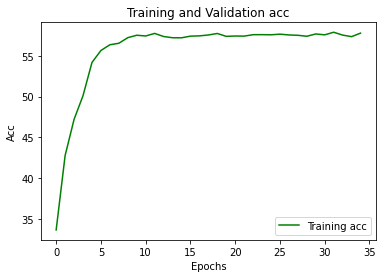

In [48]:
import matplotlib.pyplot as plt
% matplotlib inline
epochs = [x for x in range(0,35)]
# test_acc = test_acc[35:]
# train_acc = train_acc[35:]
plt.plot(epochs,train_acc, 'g', label='Training acc')
# plt.plot(epochs,test_acc, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
epochs = [x for x in range(0,15)]
plt.plot(epochs,train_losses, 'g', label='Training loss')
plt.plot(epochs,test_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()